In [3]:
# Imports
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from scipy import constants

In [4]:
# Default plot parameters
font = {'weight' : 'normal',
        'size'   : 20}

rc('font', **font)
legend_fs = 16

N = 5
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.gnuplot2(np.linspace(0,1,N)))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['image.cmap'] = 'inferno'
cmap = cm.get_cmap('inferno')


C:\Users\lucas\AppData\Local\Temp\ipykernel_28260\3302853007.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno')


<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:98: SyntaxWarning: invalid escape sequence '\e'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:110: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:98: SyntaxWarning: invalid escape sequence '\e'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:110: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_28260\1494460701.py:67: SyntaxWarning: invalid escape sequence '\m'
  cbar.ax.set_xlabel('$\mathcal{E}_z$ (mV/nm)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_28260\1494460701.py:69: SyntaxWarning: invalid escape sequence '\m'
  ax_schematic[0].set_xlabel('$t_m$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_28260\1494460701.py:98: SyntaxWarning: invalid escape sequence '\e'
  cbar_2.ax.set_xlabel('$\epsilon_m$ (%)')
C:\Users\luc

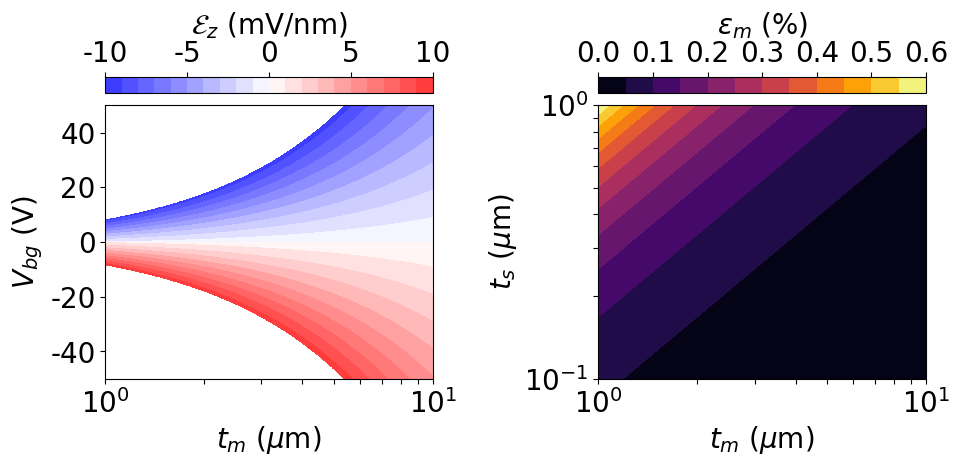

In [6]:
########### Electric field ###############

# Back-gate parameters
tg_ref_voltage = 0.8                                # Top-gate reference voltage (V)
bg_voltage = np.linspace(-50,50,1000)               # Back-gate voltages $V_{bg}$ (V)
mem_thickness = 1e-6 * np.logspace(0, 1.0, 1000)    # Membrane thickness $t_m$ (um)
qw_d = (10+30)*1e-9                                 # Quantum well depth (m)
qw_t = 10e-9                                        # Quantum well thickness (m)

tg_offset = np.zeros((len(mem_thickness),len(bg_voltage)))      # Top-gate offset required to maintain constant dot occupancy
E_z = np.zeros((len(mem_thickness),len(bg_voltage)))            # Out-of-plane electric field $\mathcal{E}_z$ (V/m)

# Calculate $\mathcal{E}_z$ at quantum well top ($V_{bg}$ < 0) / bottom ($V_{bg}$ > 0) Si/SiGe interface 
# as a function of $V_{bg}$ and $t_m$ assuming parallel-plate capacitor
for ii, bg_v in enumerate(bg_voltage):
    if bg_v < 0:
        tg_voltage = tg_ref_voltage
        tg_offset[:,ii] = -(bg_v * (qw_d / mem_thickness)) / (1-qw_d/mem_thickness)
        E_z[:,ii] = (tg_voltage + tg_offset[:,ii] - bg_v) / mem_thickness
    elif bg_v > 0:
        tg_voltage = -tg_ref_voltage * (qw_d + qw_t) / qw_d
        tg_offset[:,ii] = -(bg_v * ((qw_d + qw_t) / mem_thickness)) / (1-(qw_d+qw_t)/mem_thickness)
        E_z[:,ii] = (tg_voltage + tg_offset[:,ii] - bg_v) / mem_thickness

E_z = np.array(E_z)
    
X,Y = np.meshgrid(mem_thickness, bg_voltage)


SiGe_barrier_height = 180e-3 # eV
SiGe_barrier_thickness = 30e-9 
triangular_well_E_z = SiGe_barrier_height / SiGe_barrier_thickness

m_e = constants.electron_mass                           # Electron mass in vacuum (kg)
m_star = m_e*0.92                                       # Longitudinal effective mass for an electron in silicon
hbar = constants.hbar                                   # hbar
q_0 = constants.elementary_charge                       # Elementary charge (C)
phi_1 = SiGe_barrier_height * constants.electron_volt   # Triangular potential barrier height (J)
z_1 = 0                                                 # Reference position of top barrier edge along z
a_1 = -2.338                                            # Prefactor for ground state energy 
E = ((hbar*q_0*E_z)**2 / (2*m_star))**(1/3) * a_1       # Ground state of particle in triangular potential well
z_0 = z_1 + (E - phi_1)/(q_0 * E_z)                     # Edge of bottom barrier edge along z

# Calculate electron escape probability using Wenzel-Kramers-Brillouin approximation for a triangular potential barrier
psi = np.exp(2*np.sqrt(2*m_star)/(3*hbar*q_0*-np.abs(E_z)) * (phi_1 - np.abs(E))**(3/2)) # Wavefunction outside of quantum well
transmission_single_collision = np.abs(psi)**2  # Transmission probability of single collision

freq = np.abs(E) / (hbar * 2 * np.pi)                   # Semiclassical collision frequency with barrier wall
# T2 = 10e-6 # microsecond
T2 = 60*60*24                                           # One day (in seconds)
num_collisions = T2*freq                                # Average number of collisions in one day
transmission_multiple_collisions = 1 - (1-transmission_single_collision) ** num_collisions # Transmission probability after one day

# Mask electric fields for which electron has 99.9 % probability of escaping
masked_E_z = E_z                                
masked_E_z[transmission_multiple_collisions > 0.999] = np.nan

fig_schematic, ax_schematic = plt.subplots(1,2, figsize=(10,5))
# clim = 1e6*np.max(np.abs([x for x in masked_E_z.flatten() if x != np.nan]))
E_z_plot = ax_schematic[0].contourf(1e6*X,Y,1e-6*masked_E_z.transpose(), levels=20, 
                                    cmap='seismic', vmin=-25, vmax=25)
cbar = fig_schematic.colorbar(E_z_plot, pad=0.035, ax=ax_schematic[0], 
                              orientation='horizontal', location='top')
# cbar.ax.set_xticks([-40,-30,-20,-10,0,10], [-40,-30,-20,-10,0,10])
xtick_range = np.arange(-10,15,5)
cbar.ax.set_xticks(xtick_range, xtick_range)
cbar.ax.set_xlabel('$\mathcal{E}_z$ (mV/nm)')
ax_schematic[0].set_xscale('log')
ax_schematic[0].set_xlabel('$t_m$ ($\mu$m)')
ax_schematic[0].set_ylabel('$V_{bg}$ (V)')



########### Strain ###############

E_s = 160e9                                     # Young's modulus [100] of Si3N4 stressor
nu_s = 0.253                                    # Poisson ratio [100] of Si3N4 stressor
M_s = E_s / (1-nu_s)                            # Biaxial modulus
t_s = np.logspace(-7,-6,100)                    # Thickness of Si3N4 stressor
E_m = (130.2 - 28.1 * 0.3)*1e9                  # Young's modulus [110] of Si70Ge30 membrane
nu_m = 0.278- 0.005 * 0.3                       # Poisson ratio [110] of Si70Ge30 membrane
M_m = E_m / (1-nu_m)                            # Biaxial modulus
t_m =  1e-6 * np.logspace(0.0, 1.0, 1000)       # Thickness of Si70Ge30 membrane

X,Y = np.meshgrid(t_m, t_s)

sigma_s = -1e9                                  # (Compressive) Si3N4 stress
eps_m = []
for ii, h in enumerate(t_s):
    eps_m.append(
        -sigma_s*h / (M_m*t_m)                  # Strain sharing
    )

eps_m = np.array(eps_m)

strain_sharing_plot = ax_schematic[1].contourf(1e6*X,1e6*Y,100*eps_m, levels=11)
cbar_2 = fig_schematic.colorbar(strain_sharing_plot, pad=0.035, ax=ax_schematic[1], orientation='horizontal', location='top')
cbar_2.ax.set_xlabel('$\epsilon_m$ (%)')
ax_schematic[0].set_xticks(np.linspace(1, 10, 10), 
                           labels=['$10^0$', None, None, None, None, None, None, None, None, '$10^1$'])
ax_schematic[0].set_yticks(np.arange(-40, 50, 20), labels=np.arange(-40, 50, 20))
ax_schematic[1].set_xscale('log')
ax_schematic[1].set_yscale('log')
ax_schematic[1].set_xscale('log')
ax_schematic[1].set_xticks(np.linspace(1, 10, 10), 
                           labels=['$10^0$', None, None, None, None, None, None, None, None, '$10^1$'])
ax_schematic[1].set_yticks(np.linspace(0.1, 1, 10), 
                           labels=['$10^{-1}$', None, None, None, None, None, None, None, None, '$10^{0}$'])
ax_schematic[1].set_xlabel('$t_m$ ($\mu$m)')
ax_schematic[1].set_ylabel('$t_s$ ($\mu$m)')

fig_schematic.tight_layout()
